# Assignment 4.1 - PCA

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
S M Shameem Ahmed Khan and Rashid Harvey

---

## Grading Info/Details - Assignment 4.1:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 4.1.1 - PCA from Scratch

Implement Principal Component Analysis (PCA) from scratch using only `NumPy`.
This assignment will help you understand the mathematical foundations of PCA.

* Implement the PCA given the class structure below. **(RESULT)**
* Test your implementation using small synthetic datasets described in the test functions below. **(RESULT)**

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
class PCA:
    """
    Principal Component Analysis implementation using only NumPy.
    """
    
    def __init__(self, n_components=2):
        """
        Initialize PCA.
        """
        self.n_components = n_components
        
    def fit(self, X):
        """
        Fit PCA on the training data X.
        """
        n = X.shape[0]
        # mean-free X
        self.mean_ = np.mean(X, axis=0)
        X = X - self.mean_
        # Covariance matrix
        cov = np.dot(X.transpose(), X) / (n - 1)
        # Eigenvalues and eigenvectors
        S, W = np.linalg.eig(cov)
        # Sort W by S
        idx = np.argsort(S)[::-1]
        self.explained_variance_ = S[idx]
        self.W = W[:, idx]
    
    def transform(self, X, dim=5):
        """
        Transform X into the principal component space.
        """
        dim = min(dim, self.n_components)
        # mean-free X
        X = X - np.mean(X, axis=0)
        return np.dot(X, self.W[:, :dim])
    
    def inverse_transform(self, X):
        """
        Transform data back to original space.
        """
        return np.dot(X, self.W[:, :X.shape[1]].transpose()) + self.mean_
    
    def fit_transform(self, X):
        """
        Fit PCA and transform X in one step.
        """
        self.fit(X)
        return self.transform(X)

In [46]:
# This function was partially written using ChatGPT
def generate_pca_data(n_samples=200, n_dim=5, n_latent=2, variances=None,
                      noise_std=0.01, mean=None, random_state=None):
    """
    Generate n_dim data with n_latent dominant principal components.
    Returns X, components (n_dim x n_latent), latent variances.
    """
    rng = np.random.default_rng(random_state)
    if variances is None:
        # larger spread for first latent dims
        variances = np.linspace(5.0, 1.0, n_latent)
    variances = np.asarray(variances)
    # random orthonormal basis for the latent subspace
    A = rng.normal(size=(n_dim, n_latent))
    Q, _ = np.linalg.qr(A)             # Q has orthonormal columns (n_dim x n_latent)
    components = Q[:, :n_latent]
    # latent scores
    Z = rng.normal(scale=np.sqrt(variances), size=(n_samples, n_latent))
    # map to observed space and add small noise
    X = Z @ components.T + rng.normal(scale=noise_std, size=(n_samples, n_dim))
    if mean is not None:
        X = X + np.asarray(mean)
    return X, components, variances

def test_basic_pca():
    """Test 1: Basic PCA on 2D data"""
    X, _, _ = generate_pca_data(n_samples=100, n_dim=2, n_latent=1, variances=[3.0], noise_std=0.1, mean=(1,1), random_state=42)
    pca = PCA(n_components=1)
    Y = pca.fit_transform(X)

    print("Explained variances:", pca.explained_variance_)

    # Code from lecture (without quivers)
    _, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].scatter(X[:,0], X[:,1])
    axes[1].scatter(Y[:,0], np.zeros_like(Y[:,0]))
    plt.show()


def test_dimensionality_reduction():
    """Test 2: Reduce 5D data to 2D"""
    X, components, variances = generate_pca_data(n_samples=200, n_dim=5, n_latent=3, variances=[4.0, 3.0, 2.0], noise_std=0.05, random_state=123)
    pca = PCA(n_components=3)
    Y = pca.fit_transform(X)

    print("True variances:", variances)
    print("Explained variances:", pca.explained_variance_)

    print("True components:\n", components)
    print("Estimated components:\n", pca.W[:, :3])

    plt.scatter(Y[:,0], Y[:,1])
    plt.title("2D PCA projection")

    plt.show()

def test_reconstruction():
    """Test 3: Inverse transform (reconstruction)"""
    X, _, _ = generate_pca_data(n_samples=150, n_dim=4, n_latent=2, variances=[3.0, 2.0], noise_std=0.1, random_state=7)
    pca = PCA(n_components=2)
    Y = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(Y)

    reconstruction_error = np.mean((X - X_reconstructed) ** 2)
    print(f"Reconstruction MSE: {reconstruction_error:.6f}")


def test_variance_ordering():
    """Test 4: Components are ordered by variance"""
    print("Test 4: Verify components are ordered by explained variance")
    
    np.random.seed(42)
    X = np.random.randn(100, 5)
    
    pca = PCA(n_components=5)
    pca.fit(X)
    
    # Check that explained variances are in descending order
    variances = pca.explained_variance_
    is_sorted = np.all(variances[:-1] >= variances[1:])
    
    print(f"Explained variances: {variances}")
    print(f"Is sorted (descending): {is_sorted}")
    assert is_sorted, "Components not sorted by variance!"
    print("✓ Test 4 passed\n")


def test_centered_data():
    """Test 5: Verify data is properly centered"""
    print("Test 5: Verify data centering")
    
    np.random.seed(42)
    X = np.random.randn(100, 3) + 10  # Add offset
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    # Mean should be close to the original data mean
    print(f"Original data mean: {np.mean(X, axis=0)}")
    print(f"Stored mean: {pca.mean_}")
    print(f"Difference: {np.mean(np.abs(np.mean(X, axis=0) - pca.mean_)):.10f}")
    print("✓ Test 5 passed\n")


def run_all_tests():
    print("Running PCA test suite...\n")
    try:
        test_basic_pca()
        test_dimensionality_reduction()
        test_reconstruction()
        test_variance_ordering()
        test_centered_data()
        
        print("ALL TESTS PASSED!")
        
    except AssertionError as e:
        print(f"\n❌ Test failed: {e}")
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")

Running PCA test suite...

Explained variances: [1.85323175 0.01054215]


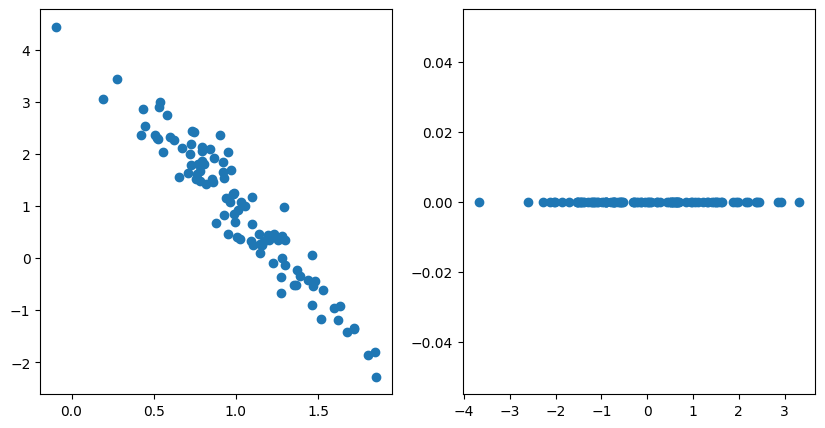

True variances: [4. 3. 2.]
Explained variances: [4.10064213e+00 3.11389448e+00 2.02886949e+00 2.64377971e-03
 2.26435507e-03]
True components:
 [[-0.57625335  0.45915601  0.56606273]
 [ 0.11300778 -0.76070427  0.45221443]
 [-0.37079809 -0.32025469  0.01668943]
 [-0.18782105 -0.02197627 -0.64979545]
 [ 0.69454543  0.32780902  0.22926498]]
Estimated components:
 [[-0.33395931  0.5617051  -0.65947761]
 [-0.14041001 -0.79965463 -0.36932821]
 [-0.45841059 -0.17163448 -0.02779354]
 [-0.22323245  0.12108691  0.62727019]
 [ 0.78024561  0.03032199 -0.18559521]]


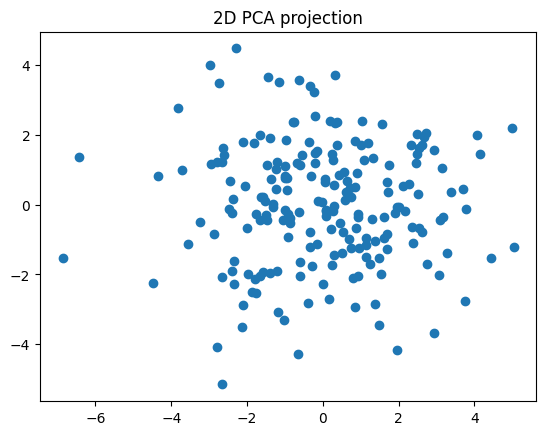

Reconstruction MSE: 0.004185
Test 4: Verify components are ordered by explained variance
Explained variances: [1.26528496 1.03990633 0.97435577 0.87353896 0.66582554]
Is sorted (descending): True
✓ Test 4 passed

Test 5: Verify data centering
Original data mean: [10.09176598  9.81676669 10.07482166]
Stored mean: [10.09176598  9.81676669 10.07482166]
Difference: 0.0000000000
✓ Test 5 passed

ALL TESTS PASSED!


In [47]:
# Run the test suite
run_all_tests()

## Task 4.1.2 - PCA on Real-World Data

* Apply your PCA implementation on the `California Housing Dataset`. **(RESULT)**
* Compare your results with those obtained from the scikit-learn PCA implementation: `sklearn.decomposition.PCA`. Are your results within numerical precision? **(RESULT)**


In [48]:
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA as SklearnPCA

In [49]:
X = fetch_california_housing().data

n_components = 3

# First, our PCA implementation
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

# Now, sklearn's PCA for comparison
sk_pca = SklearnPCA(n_components=n_components)
X_sk_reduced = sk_pca.fit_transform(X)

# Compare explained variances
print("Our PCA explained variances:", pca.explained_variance_[:n_components])
print("Sklearn PCA explained variances:", sk_pca.explained_variance_[:n_components])

# Compare components
print("Our PCA components:\n", pca.W[:, :n_components])
print("Sklearn PCA components:\n", sk_pca.components_.T)

if np.allclose(np.abs(X_reduced), np.abs(X_sk_reduced)):
    print("PCA transformations match sklearn's implementation.")



Our PCA explained variances: [1.28248501e+06 1.45311939e+02 1.06832301e+02]
Sklearn PCA explained variances: [1.28248501e+06 1.45311939e+02 1.06832301e+02]
Our PCA components:
 [[-8.11734515e-06 -1.98005360e-02 -6.72539368e-03]
 [ 3.29264421e-03  9.92216370e-01  1.15291475e-01]
 [ 1.57754708e-04 -3.90115135e-02 -6.39521503e-03]
 [ 2.77006684e-05 -4.23881026e-03 -6.14252568e-04]
 [-9.99994324e-01  3.18858393e-03  1.01475721e-03]
 [-6.40764448e-04  1.15585346e-01 -9.93283105e-01]
 [ 2.05179008e-04 -3.52344718e-03 -2.74984532e-03]
 [-1.76522227e-04 -1.38634158e-02 -1.20467341e-03]]
Sklearn PCA components:
 [[ 8.11734515e-06 -1.98005360e-02  6.72539368e-03]
 [-3.29264421e-03  9.92216370e-01 -1.15291475e-01]
 [-1.57754708e-04 -3.90115135e-02  6.39521503e-03]
 [-2.77006684e-05 -4.23881026e-03  6.14252568e-04]
 [ 9.99994324e-01  3.18858393e-03 -1.01475721e-03]
 [ 6.40764448e-04  1.15585346e-01  9.93283105e-01]
 [-2.05179008e-04 -3.52344718e-03  2.74984532e-03]
 [ 1.76522227e-04 -1.38634158e-0

## Congratz, you made it! :)